### solution3 - use lightgbm

In [78]:
import lightgbm as lgbm
import gc

In [79]:
df_5_1_test = pd.read_csv('5_1_testing.csv', sep=',', parse_dates=['trip_start_timestamp'])

In [80]:
df.shape

(992011, 17)

In [81]:
y = df[['fare']]
X = df.loc[:,['pickup_latitude','pickup_longitude','weekday','hour']]

In [89]:
y1=df[['tips']]

In [82]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaler = scaler.fit(X)
print("max:{}, min:{}".format(scaler.data_max_, scaler.data_min_))
X_mms= scaler.transform(X)

max:[784. 785.   6.  23.], min:[0. 1. 0. 0.]


In [83]:
x_train,x_test,y_train,y_test = train_test_split(X_mms,y,random_state=42,test_size=0.30)

gc.collect()

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.03,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }
train_set = lgbm.Dataset(x_train, y_train, silent=False)
valid_set = lgbm.Dataset(x_test, y_test, silent=False)
model = lgbm.train(params, train_set = train_set, num_boost_round=500,early_stopping_rounds=500,verbose_eval=500, valid_sets=valid_set)
gc.collect()

Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 7.75559
[1000]	valid_0's rmse: 7.74506
[1500]	valid_0's rmse: 7.74108
[2000]	valid_0's rmse: 7.73999
[2500]	valid_0's rmse: 7.73922
Early stopping, best iteration is:
[2363]	valid_0's rmse: 7.73909


450

In [90]:
x_train,x_test,y1_train,y1_test = train_test_split(X_mms,y1,random_state=42,test_size=0.30)

gc.collect()
train_set = lgbm.Dataset(x_train, y1_train, silent=False)
valid_set = lgbm.Dataset(x_test, y1_test, silent=False)
model_1 = lgbm.train(params, train_set = train_set, num_boost_round=500,early_stopping_rounds=500,verbose_eval=500, valid_sets=valid_set)
gc.collect()

Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 2.14786
[1000]	valid_0's rmse: 2.14745
Early stopping, best iteration is:
[701]	valid_0's rmse: 2.14745


54

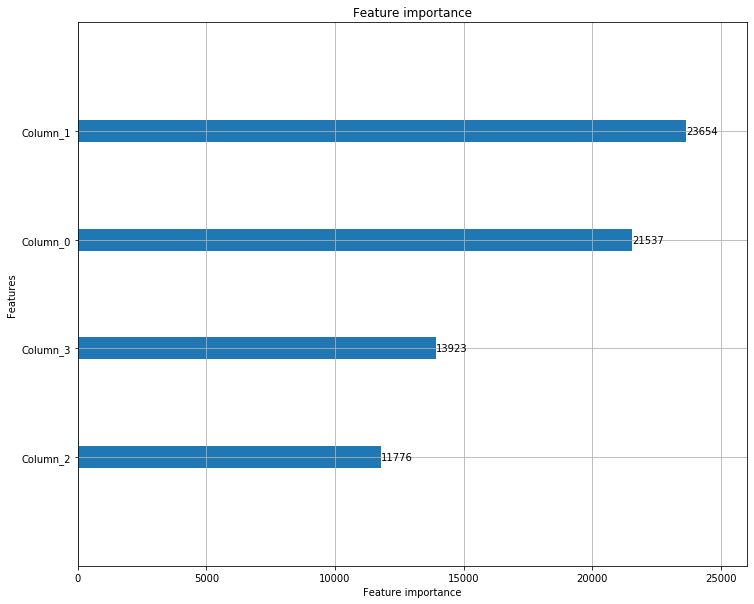

In [85]:
lgbm.plot_importance(model, figsize=(12, 10))

In [86]:
submission = model.predict(x_test)
submission

array([ 8.86761414, 12.27373914,  8.95465728, ...,  8.2670705 ,
        7.90532128, 21.29557287])

In [95]:
submission_1 = model_1.predict(x_test)
submission_1

array([1.06380928, 1.45884699, 1.20204823, ..., 0.85580085, 1.13892974,
       2.44944306])

In [87]:
#fare
r2_score(y_test, submission,multioutput='variance_weighted') 

0.5250445117502027

In [96]:
#tips
r2_score(y1_test, submission_1,multioutput='variance_weighted')

0.2771762407564743

In [88]:
s3_df_test = df_5_1_test[:]

In [101]:
s3_df_test['trip_start_timestamp'] = pd.to_datetime(s3_df_test['trip_start_timestamp'], errors='coerce')

s3_df_test['weekday'] = s3_df_test.trip_start_timestamp.apply(lambda t: t.weekday())
s3_df_test['hour'] = s3_df_test.trip_start_timestamp.apply(lambda t: t.hour)



In [106]:
def predict_fare_3():
    
    order1_predict = model.predict(s3_df_test.loc[:,['order1_pickup_latitude','order1_pickup_longitude','weekday','hour']])
    order2_predict = model.predict(s3_df_test.loc[:,['order2_pickup_latitude','order2_pickup_longitude','weekday','hour']])
    order3_predict = model.predict(s3_df_test.loc[:,['order3_pickup_latitude','order3_pickup_longitude','weekday','hour']])
    s3_df_test['order1_fare'] = order1_predict
    s3_df_test['order2_fare'] = order2_predict
    s3_df_test['order3_fare'] = order3_predict

In [107]:
def predict_tips_3():
    
    order1_predict = model_1.predict(s3_df_test.loc[:,['order1_pickup_latitude','order1_pickup_longitude','weekday','hour']])
    order2_predict = model_1.predict(s3_df_test.loc[:,['order2_pickup_latitude','order2_pickup_longitude','weekday','hour']])
    order3_predict = model_1.predict(s3_df_test.loc[:,['order3_pickup_latitude','order3_pickup_longitude','weekday','hour']])
    s3_df_test['order1_tips'] = order1_predict
    s3_df_test['order2_tips'] = order2_predict
    s3_df_test['order3_tips'] = order3_predict

In [108]:
def choose_best_3():
    for index, row in s3_df_test.iterrows():
        total1 = row['order1_fare'] + row['order1_tips']
        total2 = row['order2_fare'] + row['order2_tips']
        total3 = row['order3_fare'] + row['order3_tips']
        order_total = [total1, total2, total3]
        max_total = np.argmax(order_total) + 1
        s3_df_test.iloc[index,13]= int(max_total)

In [109]:
predict_fare_3()
predict_tips_3()
choose_best_3()

In [112]:
s1_df_test.to_csv('s3_5_1_output.csv', mode='w+', index=False,header=True)

In [110]:
s1_df_test

,order1_pickup_latitude,order1_pickup_longitude,order2_pickup_latitude,order2_pickup_longitude,order3_pickup_latitude,order3_pickup_longitude,trip_start_timestamp,order1_fare,order1_tips,order2_fare,order2_tips,order3_fare,order3_tips,best,weekday,hour
0,175.0,675.0,660.0,120.0,130.0,532.0,2016-02-01 08:00:00,12.927619,1.263593,8.887500,1.072500,17.246496,0.666667,3,0,8
1,686.0,500.0,37.0,370.0,688.0,206.0,2016-02-01 08:00:00,13.553571,0.520661,41.250000,1.134030,13.994053,0.437143,2,0,8
2,173.0,203.0,779.0,81.0,744.0,605.0,2016-02-01 08:00:00,21.265273,0.261479,13.728945,0.679979,7.450000,1.792162,1,0,8
3,660.0,120.0,419.0,615.0,175.0,675.0,2016-02-01 08:00:00,8.887500,1.072500,25.097368,0.624138,12.927619,1.263593,2,0,8
4,167.0,754.0,395.0,408.0,744.0,605.0,2016-02-01 08:00:00,14.650833,1.817292,8.717186,4.778892,7.450000,1.792162,1,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,470.0,676.0,411.0,545.0,695.0,366.0,2016-02-01 08:00:00,8.771050,0.000000,18.046319,0.681538,17.444149,0.461755,2,0,8
146,686.0,500.0,18.0,610.0,158.0,270.0,2016-02-01 08:00:00,13.553571,0.520661,9.754030,0.888532,13.916667,0.419643,3,0,8
147,599.0,346.0,64.0,231.0,744.0,605.0,2016-02-01 08:00:00,10.718289,0.937500,34.722527,0.272222,7.450000,1.792162,2,0,8
148,700.0,659.0,411.0,545.0,130.0,532.0,2016-02-01 08:00:00,12.528209,0.951195,18.046319,0.681538,17.246496,0.666667,2,0,8


In [ ]:
### solution3 - use lightgbm

import lightgbm as lgbm
import gc

df_5_1_test = pd.read_csv('5_1_testing.csv', sep=',', parse_dates=['trip_start_timestamp'])

df.shape

y = df[['fare']]
X = df.loc[:,['pickup_latitude','pickup_longitude','weekday','hour']]

y1=df[['tips']]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaler = scaler.fit(X)
print("max:{}, min:{}".format(scaler.data_max_, scaler.data_min_))
X_mms= scaler.transform(X)

x_train,x_test,y_train,y_test = train_test_split(X_mms,y,random_state=42,test_size=0.30)

gc.collect()

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.03,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }
train_set = lgbm.Dataset(x_train, y_train, silent=False)
valid_set = lgbm.Dataset(x_test, y_test, silent=False)
model = lgbm.train(params, train_set = train_set, num_boost_round=500,early_stopping_rounds=500,verbose_eval=500, valid_sets=valid_set)
gc.collect()

x_train,x_test,y1_train,y1_test = train_test_split(X_mms,y1,random_state=42,test_size=0.30)

gc.collect()
train_set = lgbm.Dataset(x_train, y1_train, silent=False)
valid_set = lgbm.Dataset(x_test, y1_test, silent=False)
model_1 = lgbm.train(params, train_set = train_set, num_boost_round=500,early_stopping_rounds=500,verbose_eval=500, valid_sets=valid_set)
gc.collect()

lgbm.plot_importance(model, figsize=(12, 10))

submission = model.predict(x_test)
submission

submission_1 = model_1.predict(x_test)
submission_1

#fare
r2_score(y_test, submission,multioutput='variance_weighted') 

#tips
r2_score(y1_test, submission_1,multioutput='variance_weighted')

s3_df_test = df_5_1_test[:]

s3_df_test['trip_start_timestamp'] = pd.to_datetime(s3_df_test['trip_start_timestamp'], errors='coerce')

s3_df_test['weekday'] = s3_df_test.trip_start_timestamp.apply(lambda t: t.weekday())
s3_df_test['hour'] = s3_df_test.trip_start_timestamp.apply(lambda t: t.hour)



def predict_fare_3():
    
    order1_predict = model.predict(s3_df_test.loc[:,['order1_pickup_latitude','order1_pickup_longitude','weekday','hour']])
    order2_predict = model.predict(s3_df_test.loc[:,['order2_pickup_latitude','order2_pickup_longitude','weekday','hour']])
    order3_predict = model.predict(s3_df_test.loc[:,['order3_pickup_latitude','order3_pickup_longitude','weekday','hour']])
    s3_df_test['order1_fare'] = order1_predict
    s3_df_test['order2_fare'] = order2_predict
    s3_df_test['order3_fare'] = order3_predict

def predict_tips_3():
    
    order1_predict = model_1.predict(s3_df_test.loc[:,['order1_pickup_latitude','order1_pickup_longitude','weekday','hour']])
    order2_predict = model_1.predict(s3_df_test.loc[:,['order2_pickup_latitude','order2_pickup_longitude','weekday','hour']])
    order3_predict = model_1.predict(s3_df_test.loc[:,['order3_pickup_latitude','order3_pickup_longitude','weekday','hour']])
    s3_df_test['order1_tips'] = order1_predict
    s3_df_test['order2_tips'] = order2_predict
    s3_df_test['order3_tips'] = order3_predict

def choose_best_3():
    for index, row in s3_df_test.iterrows():
        total1 = row['order1_fare'] + row['order1_tips']
        total2 = row['order2_fare'] + row['order2_tips']
        total3 = row['order3_fare'] + row['order3_tips']
        order_total = [total1, total2, total3]
        max_total = np.argmax(order_total) + 1
        s3_df_test.iloc[index,13]= int(max_total)

predict_fare_3()
predict_tips_3()
choose_best_3()

s1_df_test.to_csv('s3_5_1_output.csv', mode='w+', index=False,header=True)

s1_df_test

